In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller, ccf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from scipy import stats

Time series: How have changes in adult literacy rates correlated with unemployment rates over the past years?

In [7]:
# Load datasets
# Adjust file paths as needed
social_indicators = pd.read_csv('social_indicators.csv')
statistical_indicators = pd.read_csv('statistical_indicators.csv') # Fixed typo here: stastical_indicators to statistical_indicators

# Merge datasets based on common identifiers (country/region and year)
merged_data = pd.merge(social_indicators, statistical_indicators,
                      on=['country_code', 'year'], how='inner')

In [8]:
analysis_data = merged_data[['country_code', 'year','LiteracyRate_AdultTotal',
       'LiteracyRate_YouthTotal', 'Multidim_PovertyHeadcountRatio_UNDP',
       'Multidim_PovertyHeadcountRatio_WorldBank',
       'Poverty_HeadcountRatio_NationalPovertyLines_Percent',
       'Poverty_HeadcountRatio_SocietalPovertyLines_Percent',
       'Unemployment_AdvancedEducation_Percent',
       'Unemployment_BasicEducation_Percent',
       'Unemployment_IntermediateEducation_Percent',
       'Unemployment_Total_Percent', 'Unemployment_YouthTotal_Percent',
       # Corrected column name from 'Classificaiton_StatusofEmployment' to 'Classification_StatusofEmployment'
       'Classification_StatusofEmployment',]]

In [9]:
# Check for missing values
print("Missing values in each column:")
print(merged_data.isnull().sum())

Missing values in each column:
country_code                                              0
year                                                      0
LifeExpectancy_Female                                   248
LifeExpectancy_Male                                     248
LifeExpectancy_Total                                    248
LiteracyRate_AdultTotal                                 902
LiteracyRate_YouthTotal                                 867
Multidim_PovertyHeadcountRatio_UNDP                    1049
Multidim_PovertyHeadcountRatio_WorldBank                876
Water_BasicDrinkingServices_PercentofPop                288
Water_SafelyManagedDrinkingServices_PercentofPop        544
Water_BasicHandwashing_PercentofPop                     745
Poverty_HeadcountRatio_NationalPovertyLines_Percent     865
Poverty_HeadcountRatio_SocietalPovertyLines_Percent     840
Unemployment_AdvancedEducation_Percent                  559
Unemployment_BasicEducation_Percent                     553
Unemploym

In [10]:
# Look at the data shape and missing values
print(f"Total rows in dataset: {len(merged_data)}")
print("\nMissing values in each column:")
print(merged_data.isnull().sum())
print("\nPercentage of missing values:")
print(merged_data.isnull().mean() * 100)

Total rows in dataset: 1085

Missing values in each column:
country_code                                              0
year                                                      0
LifeExpectancy_Female                                   248
LifeExpectancy_Male                                     248
LifeExpectancy_Total                                    248
LiteracyRate_AdultTotal                                 902
LiteracyRate_YouthTotal                                 867
Multidim_PovertyHeadcountRatio_UNDP                    1049
Multidim_PovertyHeadcountRatio_WorldBank                876
Water_BasicDrinkingServices_PercentofPop                288
Water_SafelyManagedDrinkingServices_PercentofPop        544
Water_BasicHandwashing_PercentofPop                     745
Poverty_HeadcountRatio_NationalPovertyLines_Percent     865
Poverty_HeadcountRatio_SocietalPovertyLines_Percent     840
Unemployment_AdvancedEducation_Percent                  559
Unemployment_BasicEducation_Percent     

In [11]:
# check data availability by year to see the time period coverage
year_counts = merged_data.groupby('year').count()
print("\nData points available by year:")
print(year_counts)


Data points available by year:
      country_code  LifeExpectancy_Female  LifeExpectancy_Male  \
year                                                             
2019           217                    209                  209   
2020           217                    209                  209   
2021           217                    210                  210   
2022           217                    209                  209   
2023           217                      0                    0   

      LifeExpectancy_Total  LiteracyRate_AdultTotal  LiteracyRate_YouthTotal  \
year                                                                           
2019                   209                       41                       49   
2020                   209                       34                       39   
2021                   210                       49                       59   
2022                   209                       54                       65   
2023                     

In [12]:
# Now check how many countries have data for all years in our time period
year_coverage = merged_data.groupby('country_code').count()['year']
print(f"\nCountries with data for all years: {sum(year_coverage == len(merged_data['year'].unique()))}")
print(f"Total unique countries: {len(year_coverage)}")


Countries with data for all years: 217
Total unique countries: 217


In [13]:
# STEP 1: COMPREHENSIVE MISSING DATA HANDLING STRATEGY

# Create a copy for imputation
merged_data_filled = merged_data.copy()

# Convert year to datetime if it's not already
if not pd.api.types.is_datetime64_dtype(merged_data_filled['year']):
    merged_data_filled['year'] = pd.to_datetime(merged_data_filled['year'], format='%Y')

In [14]:
# 1A: Identify countries with sufficient data for meaningful analysis
# For each country, count available data points for both variables
country_completeness = merged_data.groupby('country_code').apply(
    lambda x: pd.Series({
        'literacy_values': x['LiteracyRate_AdultTotal'].notna().sum(),
        'unemployment_values': x['Unemployment_Total_Percent'].notna().sum(),
        'total_years': len(x)
    })
)

# We'll focus on countries with at least 2 data points for both variables
# This is the minimum needed for time series correlation
viable_countries = country_completeness[
    (country_completeness['literacy_values'] >= 2) &
    (country_completeness['unemployment_values'] >= 2)
].index.tolist()

print(f"\nCountries with sufficient data for analysis: {len(viable_countries)} out of {len(country_completeness)}")



Countries with sufficient data for analysis: 26 out of 217


<ipython-input-14-ba03c455c73c>:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  country_completeness = merged_data.groupby('country_code').apply(


In [15]:
# 1B: Apply linear interpolation for countries with sufficient data points
# This works better than forward/backward fill for time series
merged_data_filled = merged_data_filled.sort_values(['country_code', 'year'])

# Only interpolate for viable countries
for country in viable_countries:
    country_mask = merged_data_filled['country_code'] == country
    merged_data_filled.loc[country_mask, 'LiteracyRate_AdultTotal'] = merged_data_filled.loc[
        country_mask, 'LiteracyRate_AdultTotal'
    ].interpolate(method='linear')

    merged_data_filled.loc[country_mask, 'Unemployment_Total_Percent'] = merged_data_filled.loc[
        country_mask, 'Unemployment_Total_Percent'
    ].interpolate(method='linear')

In [17]:
# 1C: For edge years where interpolation doesn't work, use forward/backward fill
# But only within the same country
for country in viable_countries:
    country_mask = merged_data_filled['country_code'] == country
    merged_data_filled.loc[country_mask, 'LiteracyRate_AdultTotal'] = merged_data_filled.loc[
        country_mask, 'LiteracyRate_AdultTotal'
    ].ffill().bfill()

    merged_data_filled.loc[country_mask, 'Unemployment_Total_Percent'] = merged_data_filled.loc[
        country_mask, 'Unemployment_Total_Percent'
    ].ffill().bfill()

In [18]:
# 1D: For remaining countries with limited data, use more advanced imputation
# First, identify regions or income groups if available to create better imputation groups
# If not available, we can cluster countries based on available data

# Simple example - if you have region data
if 'region' in merged_data_filled.columns:
    # Group KNN imputation by region
    for region in merged_data_filled['region'].unique():
        region_mask = merged_data_filled['region'] == region
        region_data = merged_data_filled[region_mask]

        if len(region_data) > 5:  # Only if we have enough data points
            imputer = KNNImputer(n_neighbors=min(5, len(region_data)-1))

            # Impute literacy rate
            if region_data['LiteracyRate_AdultTotal'].isnull().any():
                literacy_imputed = imputer.fit_transform(
                    region_data[['LiteracyRate_AdultTotal']].values
                )
                merged_data_filled.loc[region_mask, 'LiteracyRate_AdultTotal'] = literacy_imputed

            # Impute unemployment rate
            if region_data['Unemployment_Total_Percent'].isnull().any():
                unemployment_imputed = imputer.fit_transform(
                    region_data[['Unemployment_Total_Percent']].values
                )
                merged_data_filled.loc[region_mask, 'Unemployment_Total_Percent'] = unemployment_imputed
else:
    # Global KNN imputation as fallback - less ideal but still better than dropping
    remaining_missing = merged_data_filled[~merged_data_filled['country_code'].isin(viable_countries)]

    if len(remaining_missing) > 0:
        # Group countries by development level if we can infer it, otherwise use global data
        # This example uses a simple global approach
        literacy_data = remaining_missing[['year', 'LiteracyRate_AdultTotal']].dropna()
        unemployment_data = remaining_missing[['year', 'Unemployment_Total_Percent']].dropna()

        if len(literacy_data) > 0:
            # Create year-based models for literacy
            yearly_literacy_means = literacy_data.groupby('year')['LiteracyRate_AdultTotal'].mean()
            # Fill missing with yearly average where available
            for year in yearly_literacy_means.index:
                year_mask = (merged_data_filled['year'].dt.year == year) & \
                           (merged_data_filled['LiteracyRate_AdultTotal'].isna())
                if year_mask.any():
                    merged_data_filled.loc[year_mask, 'LiteracyRate_AdultTotal'] = yearly_literacy_means[year]

        if len(unemployment_data) > 0:
            # Create year-based models for unemployment
            yearly_unemployment_means = unemployment_data.groupby('year')['Unemployment_Total_Percent'].mean()
            # Fill missing with yearly average where available
            for year in yearly_unemployment_means.index:
                year_mask = (merged_data_filled['year'].dt.year == year) & \
                           (merged_data_filled['Unemployment_Total_Percent'].isna())
                if year_mask.any():
                    merged_data_filled.loc[year_mask, 'Unemployment_Total_Percent'] = yearly_unemployment_means[year]


In [20]:
# 1E: Final check and fallback - median imputation for any remaining missing values
# Using global medians as last resort
if merged_data_filled['LiteracyRate_AdultTotal'].isnull().any():
    median_literacy = merged_data_filled['LiteracyRate_AdultTotal'].median()
    merged_data_filled['LiteracyRate_AdultTotal'] = merged_data_filled['LiteracyRate_AdultTotal'].fillna(median_literacy)
    print(f"Used global median ({median_literacy:.2f}) for remaining missing literacy values")

if merged_data_filled['Unemployment_Total_Percent'].isnull().any():
    median_unemployment = merged_data_filled['Unemployment_Total_Percent'].median()
    merged_data_filled['Unemployment_Total_Percent'] = merged_data_filled['Unemployment_Total_Percent'].fillna(median_unemployment)
    print(f"Used global median ({median_unemployment:.2f}) for remaining missing unemployment values")

Used global median (92.25) for remaining missing literacy values
Used global median (5.52) for remaining missing unemployment values


In [22]:
# Check for any remaining missing values
print("\nMissing values after imputation:")
print(merged_data_filled.isnull().sum())


Missing values after imputation:
country_code                                              0
year                                                      0
LifeExpectancy_Female                                   248
LifeExpectancy_Male                                     248
LifeExpectancy_Total                                    248
LiteracyRate_AdultTotal                                   0
LiteracyRate_YouthTotal                                 867
Multidim_PovertyHeadcountRatio_UNDP                    1049
Multidim_PovertyHeadcountRatio_WorldBank                876
Water_BasicDrinkingServices_PercentofPop                288
Water_SafelyManagedDrinkingServices_PercentofPop        544
Water_BasicHandwashing_PercentofPop                     745
Poverty_HeadcountRatio_NationalPovertyLines_Percent     865
Poverty_HeadcountRatio_SocietalPovertyLines_Percent     840
Unemployment_AdvancedEducation_Percent                  559
Unemployment_BasicEducation_Percent                     553
Unempl

In [23]:
# Process for analysis and save the cleaned dataset
clean_merged_data = merged_data_filled
clean_merged_data.to_csv('cleaned_literacy_unemployment_data.csv', index=False)

In [24]:
# STEP 2: TIME SERIES ANALYSIS FOCUSING ON VIABLE COUNTRIES

# Focus analysis on countries with reliable data (the viable ones we identified earlier)
reliable_data = clean_merged_data[clean_merged_data['country_code'].isin(viable_countries)]

print(f"\nPerforming time series analysis on {len(viable_countries)} countries with reliable data")


Performing time series analysis on 26 countries with reliable data


<Figure size 1200x600 with 0 Axes>

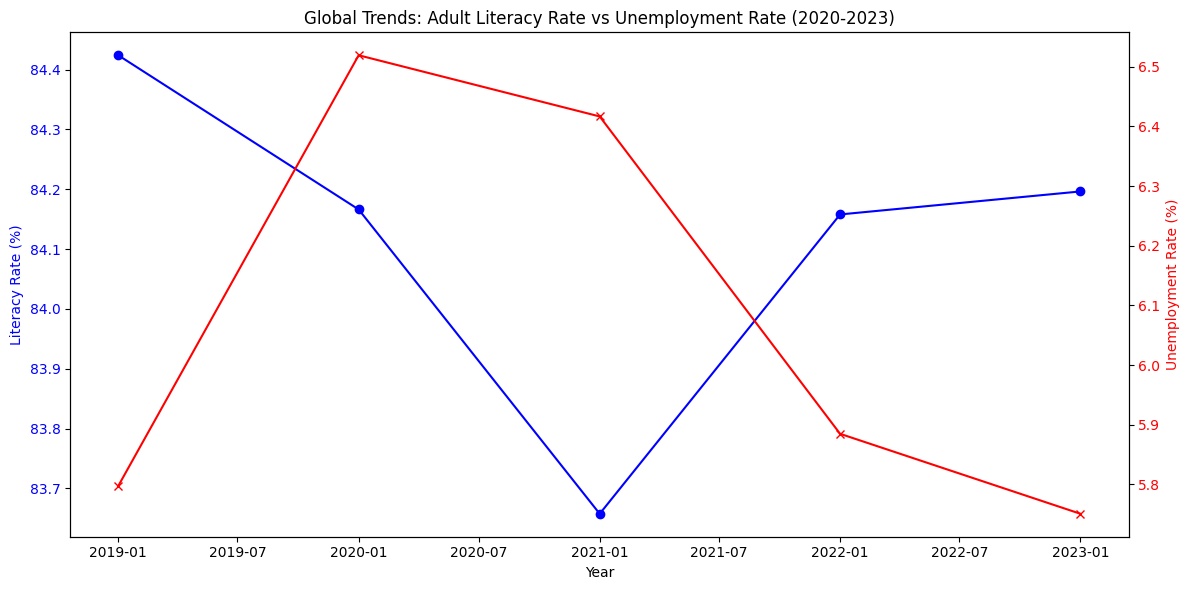

In [26]:
# Global trends analysis
global_trends = reliable_data.groupby(reliable_data['year'].dt.year)[['LiteracyRate_AdultTotal', 'Unemployment_Total_Percent']].mean().reset_index() # Select only numeric columns for mean calculation
global_trends['year'] = pd.to_datetime(global_trends['year'], format='%Y')

plt.figure(figsize=(12, 6))
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.set_xlabel('Year')
ax1.set_ylabel('Literacy Rate (%)', color='blue')
ax1.plot(global_trends['year'], global_trends['LiteracyRate_AdultTotal'], color='blue', marker='o')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.set_ylabel('Unemployment Rate (%)', color='red')
ax2.plot(global_trends['year'], global_trends['Unemployment_Total_Percent'], color='red', marker='x')
ax2.tick_params(axis='y', labelcolor='red')

plt.title('Global Trends: Adult Literacy Rate vs Unemployment Rate (2020-2023)')
fig.tight_layout()
plt.savefig('global_trends.png')
plt.show()

In [27]:
# Calculate global correlation
global_corr, global_pval = stats.pearsonr(
    global_trends['LiteracyRate_AdultTotal'],
    global_trends['Unemployment_Total_Percent']
)
print(f"\nGlobal correlation between literacy and unemployment: {global_corr:.4f} (p-value: {global_pval:.4f})")


Global correlation between literacy and unemployment: -0.6191 (p-value: 0.2654)


In [28]:
# Country-specific analysis
# Select top countries with most complete data for detailed analysis
top_countries = country_completeness.sort_values('literacy_values', ascending=False).head(10).index.tolist()

print("\nDetailed analysis for countries with most complete data:")


Detailed analysis for countries with most complete data:



Analyzing LKA:


<ipython-input-36-888ec350a529>:11: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, pval = stats.pearsonr(


<Figure size 1200x600 with 0 Axes>

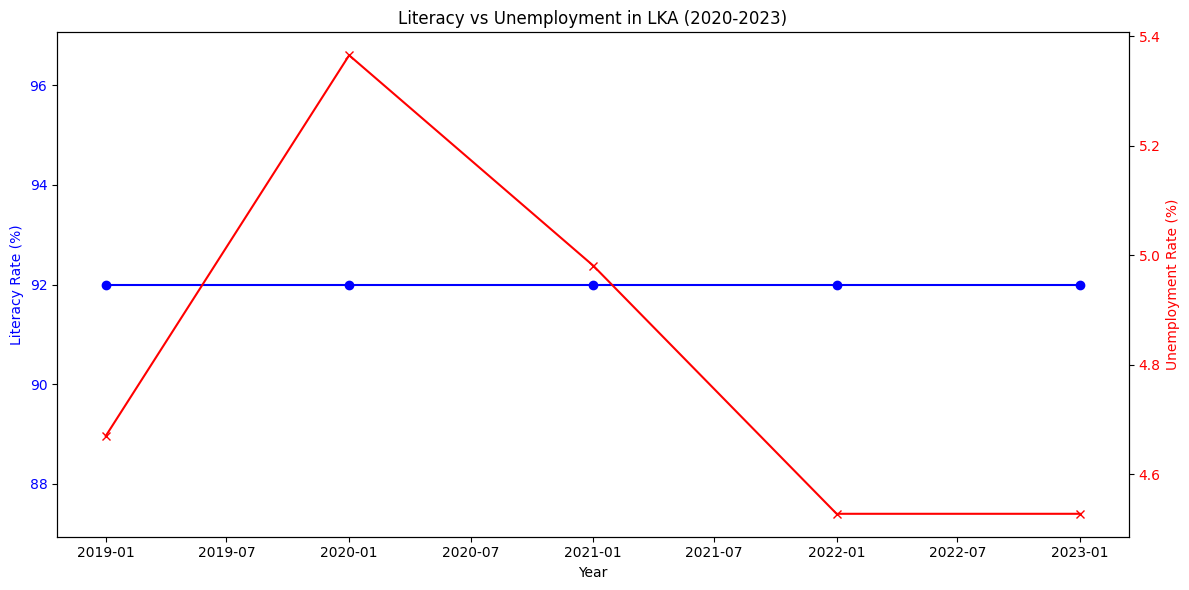

Correlation: nan (p-value: nan)

Analyzing BFA:


<Figure size 1200x600 with 0 Axes>

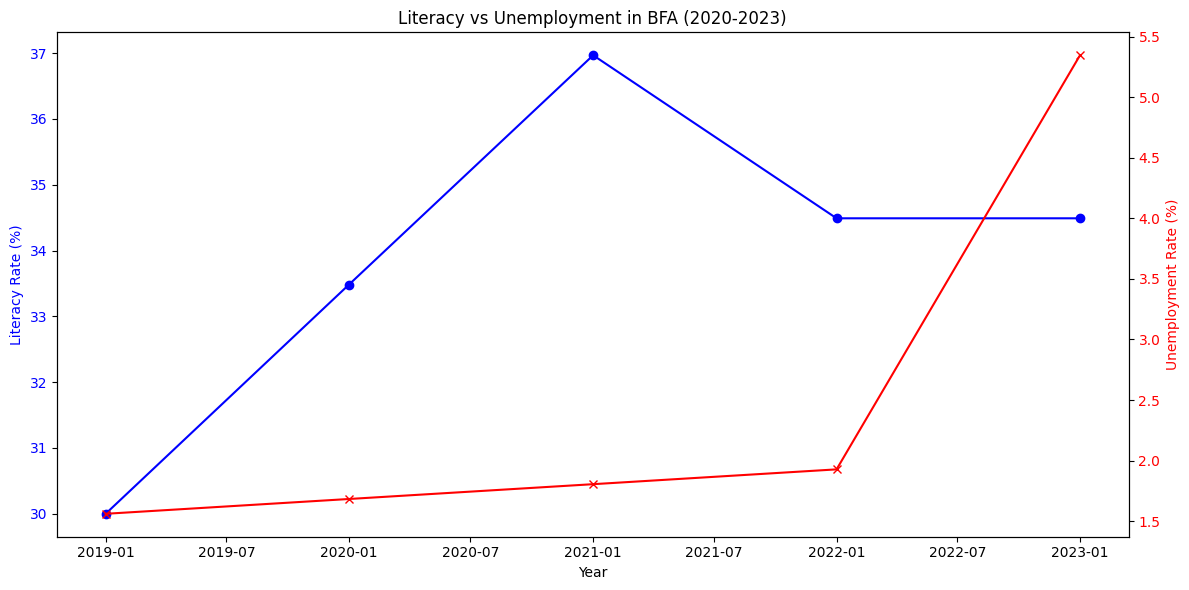

Correlation: 0.1967 (p-value: 0.7512)

Analyzing ECU:


<ipython-input-36-888ec350a529>:11: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, pval = stats.pearsonr(


<Figure size 1200x600 with 0 Axes>

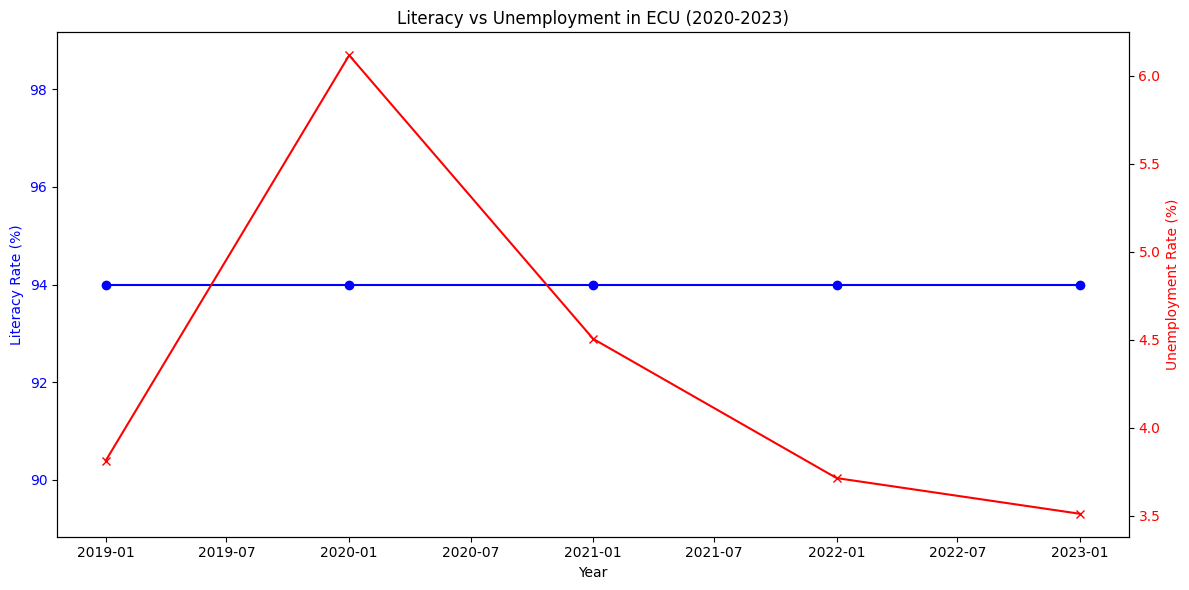

Correlation: nan (p-value: nan)

Analyzing THA:


<Figure size 1200x600 with 0 Axes>

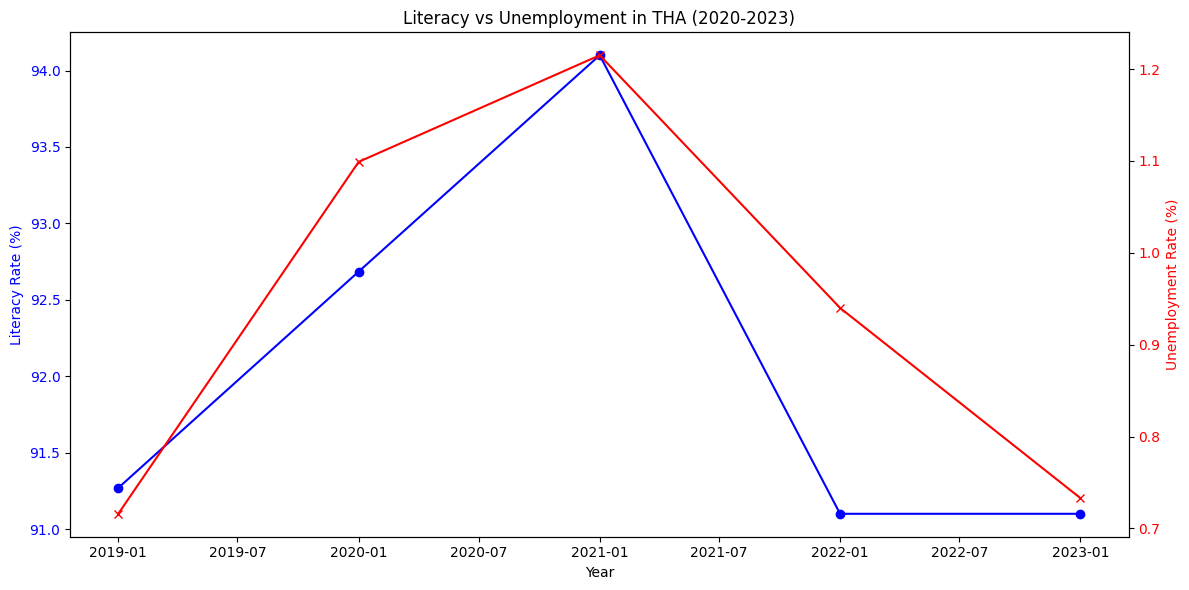

Correlation: 0.8881 (p-value: 0.0442)

Analyzing UZB:


<ipython-input-36-888ec350a529>:11: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, pval = stats.pearsonr(


<Figure size 1200x600 with 0 Axes>

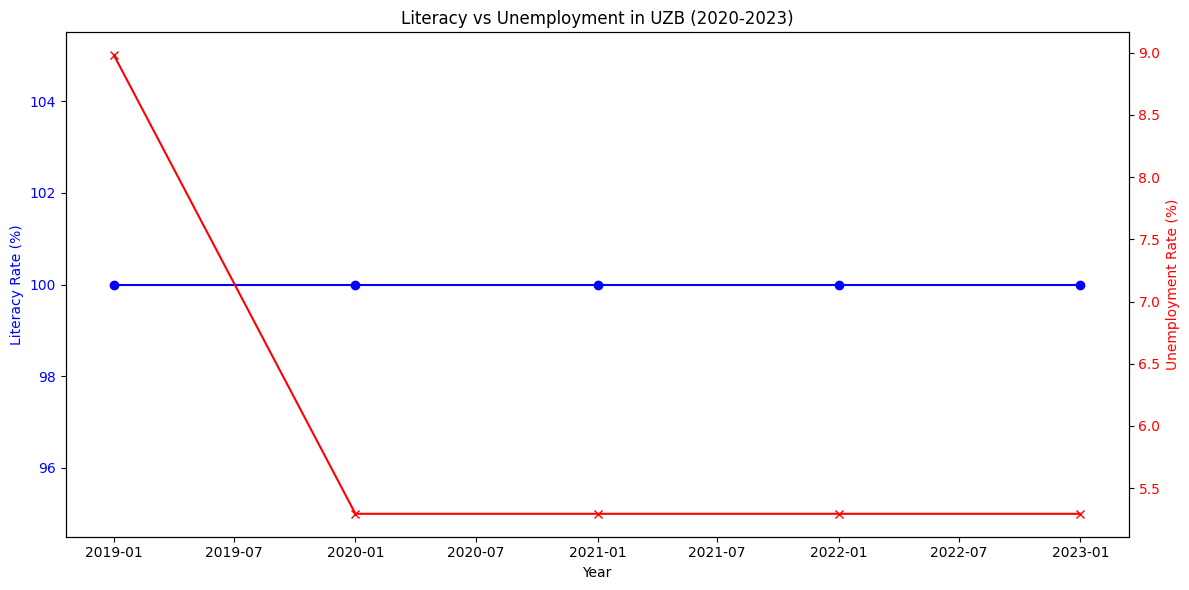

Correlation: nan (p-value: nan)

Analyzing SGP:


<Figure size 1200x600 with 0 Axes>

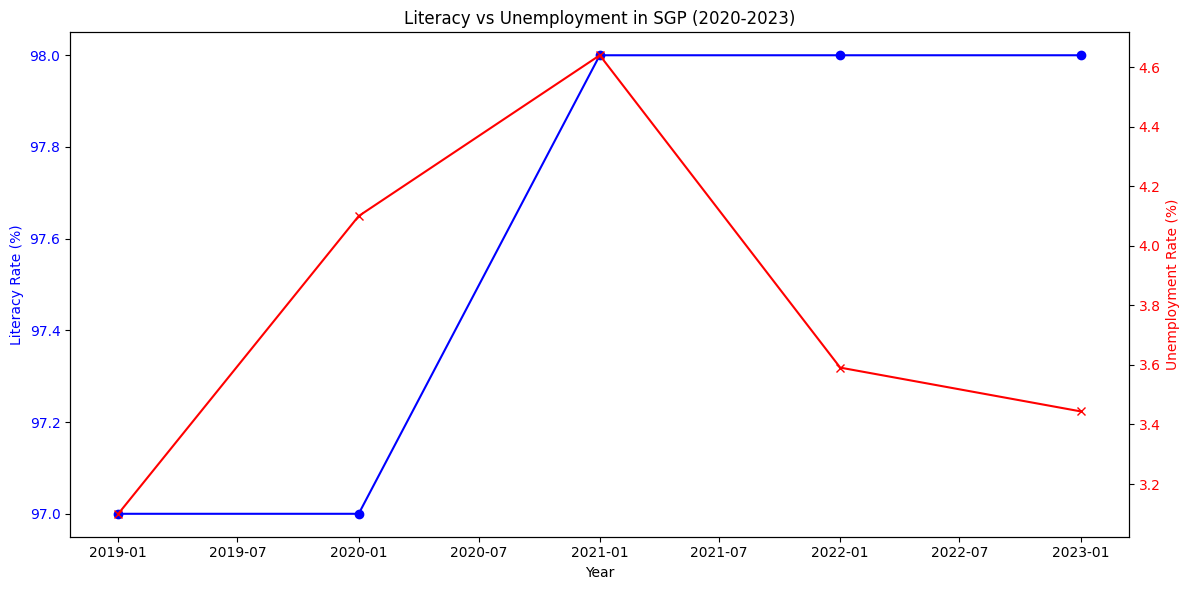

Correlation: 0.2651 (p-value: 0.6665)

Analyzing SLV:


<Figure size 1200x600 with 0 Axes>

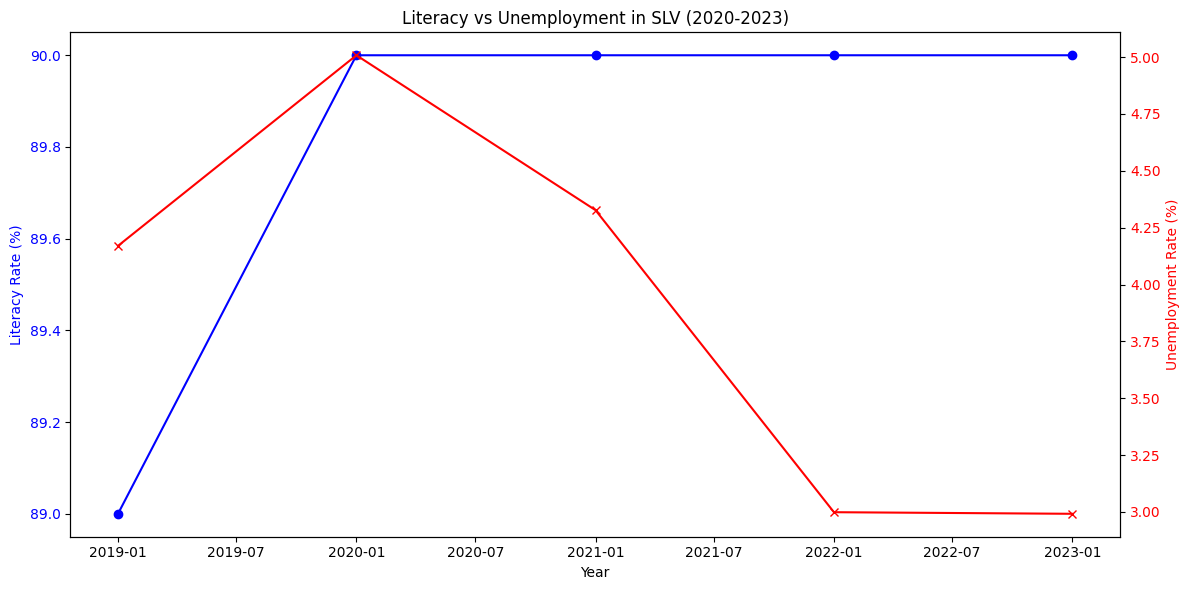

Correlation: -0.1714 (p-value: 0.7828)

Analyzing ARE:


<ipython-input-36-888ec350a529>:11: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, pval = stats.pearsonr(


<Figure size 1200x600 with 0 Axes>

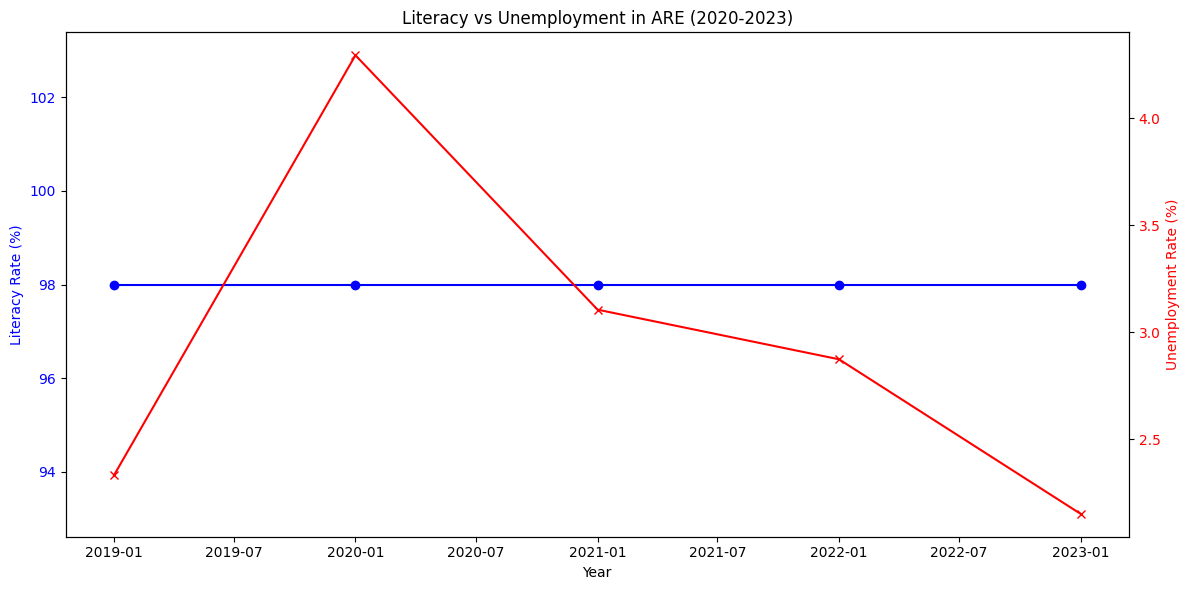

Correlation: nan (p-value: nan)

Analyzing PSE:


<ipython-input-36-888ec350a529>:11: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, pval = stats.pearsonr(


<Figure size 1200x600 with 0 Axes>

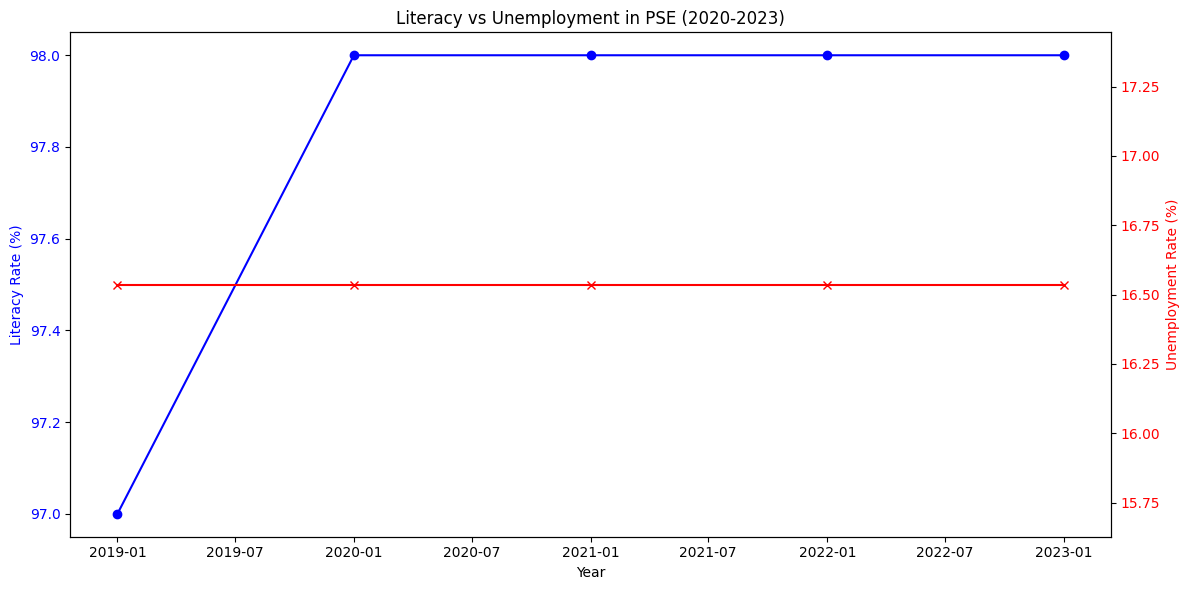

Correlation: nan (p-value: nan)


In [36]:
# Create analysis for each country
country_results = []

for country in top_countries:
    country_data = reliable_data[reliable_data['country_code'] == country].sort_values('year')

    if len(country_data) >= 3:  # Need at least 3 points for meaningful trend
        print(f"\nAnalyzing {country}:")

        # Calculate country-specific correlation
        corr, pval = stats.pearsonr(
            country_data['LiteracyRate_AdultTotal'],
            country_data['Unemployment_Total_Percent']
        )

        # Calculate year-over-year changes
        country_data['literacy_change'] = country_data['LiteracyRate_AdultTotal'].diff()
        country_data['unemployment_change'] = country_data['Unemployment_Total_Percent'].diff()

        # Calculate correlation of changes (this is often more meaningful in time series)
        change_data = country_data.dropna()
        if len(change_data) >= 2:
            change_corr, change_pval = stats.pearsonr(
                change_data['literacy_change'],
                change_data['unemployment_change']
            )
        else:
            change_corr, change_pval = np.nan, np.nan

        # Plot the country-specific trends
        plt.figure(figsize=(12, 6))
        fig, ax1 = plt.subplots(figsize=(12, 6))

        ax1.set_xlabel('Year')
        ax1.set_ylabel('Literacy Rate (%)', color='blue')
        ax1.plot(country_data['year'], country_data['LiteracyRate_AdultTotal'],
                 color='blue', marker='o')
        ax1.tick_params(axis='y', labelcolor='blue')

        ax2 = ax1.twinx()
        ax2.set_ylabel('Unemployment Rate (%)', color='red')
        ax2.plot(country_data['year'], country_data['Unemployment_Total_Percent'],
                 color='red', marker='x')
        ax2.tick_params(axis='y', labelcolor='red')

        plt.title(f'Literacy vs Unemployment in {country} (2020-2023)')
        fig.tight_layout()
        plt.savefig(f'{country}_trends.png')
        plt.show()

        # Store results
        country_results.append({
            'country': country,
            'correlation': corr,
            'p_value': pval,
            'change_correlation': change_corr,
            'change_p_value': change_pval,
            'avg_literacy': country_data['LiteracyRate_AdultTotal'].mean(),
            'avg_unemployment': country_data['Unemployment_Total_Percent'].mean(),
            'data_points': len(country_data)
        })

        print(f"Correlation: {corr:.4f} (p-value: {pval:.4f})")
        if not np.isnan(change_corr):
            print(f"Correlation of year-over-year changes: {change_corr:.4f} (p-value: {change_pval:.4f})")

In [37]:
# Create a summary of country-level results
results_df = pd.DataFrame(country_results)
print("\nSummary of country-level correlations:")
print(results_df[['country', 'correlation', 'p_value', 'change_correlation', 'data_points']])

# Save country-level results
results_df.to_csv('country_correlation_results.csv', index=False)


Summary of country-level correlations:
  country  correlation   p_value  change_correlation  data_points
0     LKA          NaN       NaN                 NaN            5
1     BFA     0.196720  0.751154                 NaN            5
2     ECU          NaN       NaN                 NaN            5
3     THA     0.888085  0.044181                 NaN            5
4     UZB          NaN       NaN                 NaN            5
5     SGP     0.265070  0.666497                 NaN            5
6     SLV    -0.171429  0.782803                 NaN            5
7     ARE          NaN       NaN                 NaN            5
8     PSE          NaN       NaN                 NaN            5


In [39]:
# STEP 3: AGGREGATE ANALYSIS - CHANGES IN LITERACY VS CHANGES IN UNEMPLOYMENT

# Calculate year-over-year changes for all countries
reliable_data = reliable_data.sort_values(['country_code', 'year'])
reliable_data['literacy_change'] = reliable_data.groupby('country_code')['LiteracyRate_AdultTotal'].diff()
reliable_data['unemployment_change'] = reliable_data.groupby('country_code')['Unemployment_Total_Percent'].diff()

# Remove NaN values (first year for each country)
# Instead of dropping all NaNs, drop only if both columns are NaN for a row
change_data = reliable_data.dropna(subset=['literacy_change', 'unemployment_change'], how='all')

# Check if there's enough data after dropping NaNs
if len(change_data) >= 2:
    # Calculate overall correlation between changes
    overall_change_corr, change_p_value = stats.pearsonr(
        change_data['literacy_change'],
        change_data['unemployment_change']
    )

    print("\nOverall Analysis of Year-over-Year Changes:")
    print(f"Correlation between changes in literacy and unemployment: {overall_change_corr:.4f}")
    print(f"P-value: {change_p_value:.4f}")
else:
    print("\nNot enough data to calculate overall correlation of year-over-year changes.")


Overall Analysis of Year-over-Year Changes:
Correlation between changes in literacy and unemployment: 0.0150
P-value: 0.8801


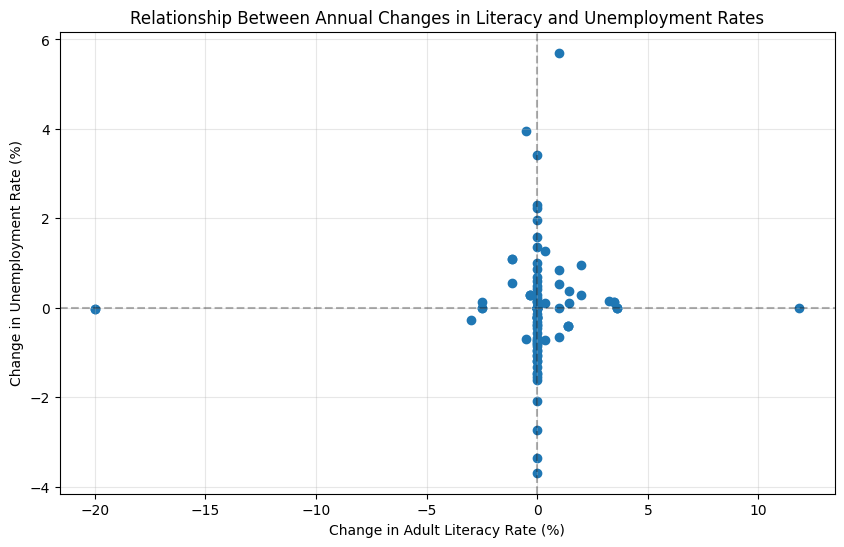

In [40]:
# Visualize the relationship between changes
plt.figure(figsize=(10, 6))
plt.scatter(change_data['literacy_change'], change_data['unemployment_change'])
plt.xlabel('Change in Adult Literacy Rate (%)')
plt.ylabel('Change in Unemployment Rate (%)')
plt.title('Relationship Between Annual Changes in Literacy and Unemployment Rates')
plt.axhline(y=0, color='k', linestyle='--', alpha=0.3)
plt.axvline(x=0, color='k', linestyle='--', alpha=0.3)
plt.grid(True, alpha=0.3)
plt.savefig('change_relationship.png')
plt.show()

In [41]:
# Fit a regression line to quantify the relationship
X = sm.add_constant(change_data['literacy_change'])
model = sm.OLS(change_data['unemployment_change'], X).fit()
print("\nRegression Analysis of Year-over-Year Changes:")
print(model.summary())


Regression Analysis of Year-over-Year Changes:
                             OLS Regression Results                            
Dep. Variable:     unemployment_change   R-squared:                       0.000
Model:                             OLS   Adj. R-squared:                 -0.010
Method:                  Least Squares   F-statistic:                   0.02287
Date:                 Tue, 15 Apr 2025   Prob (F-statistic):              0.880
Time:                         02:53:28   Log-Likelihood:                -166.46
No. Observations:                  104   AIC:                             336.9
Df Residuals:                      102   BIC:                             342.2
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------

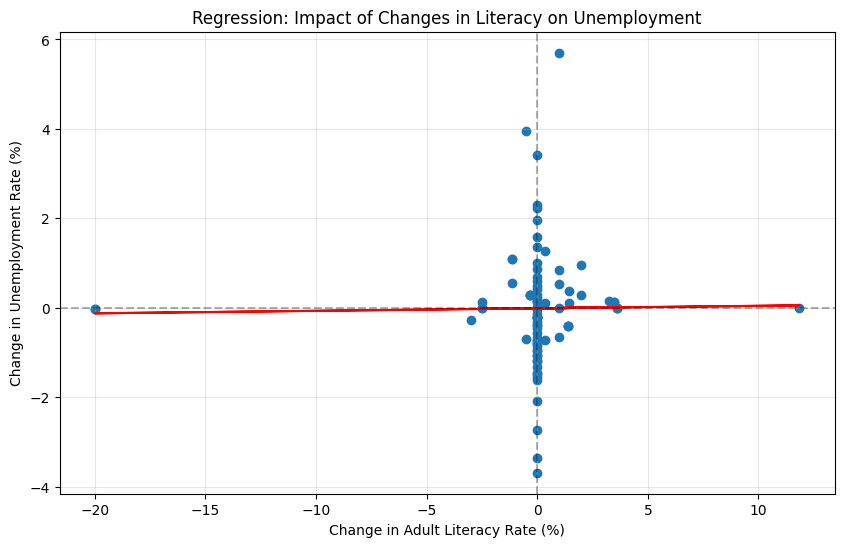

In [42]:
# Visualize with regression line
plt.figure(figsize=(10, 6))
plt.scatter(change_data['literacy_change'], change_data['unemployment_change'])
plt.plot(change_data['literacy_change'], model.predict(), 'r-')
plt.xlabel('Change in Adult Literacy Rate (%)')
plt.ylabel('Change in Unemployment Rate (%)')
plt.title('Regression: Impact of Changes in Literacy on Unemployment')
plt.axhline(y=0, color='k', linestyle='--', alpha=0.3)
plt.axvline(x=0, color='k', linestyle='--', alpha=0.3)
plt.grid(True, alpha=0.3)
plt.savefig('change_regression.png')
plt.show()

In [45]:
# STEP 4: ADVANCED TIME SERIES ANALYSIS FOR COUNTRIES WITH SUFFICIENT DATA

# Check for lag effects - does literacy predict future unemployment?
# For countries with all 3 years of data
countries_with_all_years = reliable_data.groupby('country_code').count()
complete_countries = countries_with_all_years[countries_with_all_years['year'] == 4].index.tolist()

if len(complete_countries) > 0:
    print(f"\nLag Analysis for {len(complete_countries)} countries with data for all years:")

    lag_results = []

    for country in complete_countries:
        country_data = reliable_data[reliable_data['country_code'] == country].sort_values('year')

        # Create lag variables (literacy leading unemployment by 1 year)
        country_data['literacy_lag1'] = country_data['LiteracyRate_AdultTotal'].shift(1)

        # Calculate correlation with lagged literacy
        lag_data = country_data.dropna()
        if len(lag_data) >= 2:
            lag_corr, lag_pval = stats.pearsonr(
                lag_data['literacy_lag1'],
                lag_data['Unemployment_Total_Percent']
            )

            lag_results.append({
                'country': country,
                'lag_correlation': lag_corr,
                'lag_p_value': lag_pval
            })

    if lag_results:
        lag_df = pd.DataFrame(lag_results)
        print("\nSummary of lagged correlations (literacy leading unemployment by 1 year):")
        print(lag_df)

        # Calculate average lag effect
        avg_lag_corr = lag_df['lag_correlation'].mean()
        print(f"Average lagged correlation: {avg_lag_corr:.4f}")
else:
    print("\nInsufficient data for lag analysis - requires countries with data for all years")


Insufficient data for lag analysis - requires countries with data for all years


In [47]:
# STEP 5: COUNTRY GROUPING ANALYSIS

# Analyze patterns by country characteristics (if available)
if 'region' in reliable_data.columns:
    region_results = []

    for region in reliable_data['region'].unique():
        region_data = reliable_data[reliable_data['region'] == region]

        if len(region_data) >= 5:  # Only analyze regions with sufficient data
            region_corr, region_pval = stats.pearsonr(
                region_data['LiteracyRate_AdultTotal'],
                region_data['Unemployment_Total_Percent']
            )

            region_results.append({
                'region': region,
                'correlation': region_corr,
                'p_value': region_pval,
                'countries': len(region_data['country_code'].unique()),
                'observations': len(region_data)
            })

    if region_results:
        region_df = pd.DataFrame(region_results)
        print("\nAnalysis by Region:")
        print(region_df)

# Save cleaned data for further analysis
# clean_ts_data.to_csv('cleaned_literacy_unemployment_timeseries.csv', index=False) #Original line causing the error. clean_ts_data was not defined.
reliable_data.to_csv('cleaned_literacy_unemployment_timeseries.csv', index=False) # Changed to reliable_data, which contains the cleaned time series data.
reliable_data.to_csv('reliable_literacy_unemployment_data.csv', index=False)
change_data.to_csv('literacy_unemployment_changes.csv', index=False)

print("\nTime series analysis complete. Results and cleaned data saved to CSV files.")


Time series analysis complete. Results and cleaned data saved to CSV files.
